In [1]:
import numpy as np
import fasttext as ft
from random import *
from sklearn import metrics
from utility.loaders import *
from utility.writers import *
from utility.otherUtility import *
from utility.labelingFunctions import *
from utility.gloveUtil import *
from utility.gensimModelUtil import *
from utility.twokenize import tokenizeRawTweetText as tknzr
import matplotlib.pyplot as plt
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier

In [2]:
joinedComments = textLoader("manuallyLabeledComments/joinedComments.txt", "str")
joinedComments = [x for x in joinedComments if x[0] in ["0", "1"]]
shuffle(joinedComments)
splitRatio = 0.8
splitPoint = int(splitRatio*len(joinedComments))
trainingData = joinedComments[:splitPoint]
testingData = joinedComments[splitPoint:]
print(len(trainingData), len(testingData))

1985 497


In [3]:
class Classifier():
    '''
    Following values need to be given:
    1.  Training Data and Testing Data (trData, tsData)
        Format:
        int, str
        int, str
        .
        .
        .
        int, str
    2.  Preprocess (pp)
        Defines if data undergoes preprocessing or not.
        Allowed Values: True or False
    3.  Transformation (tr)
        Defines how will embedding be obtained for given
        documents, can choose between fasttext and tf-idf
        Allowed Values: 'ft'
    4.  Iterations (itr)
        Maximum number of expansion attempts, values need
        to be suitable based on batch size
        Allowed Values: int
    5.  Initial Seed Size (ss)
        Describes the number of comments in initial seed
        Allowed Values: int
    6.  Batch Size (bs)
        Number of comments being inserted at a time,
        minimum value of 1
        Allowed Values: int
    7.  Query Strategy (qs)
        Defines strategy for selecting comments to include in
        seed set.
        Allowed Values:
        'lcs' : Least Confident Sampling 
        'ms' : Margin Sampling
        'es' : Entropy Sampling
    8.  Weak Supervision/Labeling Functions (lf)
        Number of labeling functions to use, cannot use
        more than implemented.
        Allowed Values: int
    9.  Type of labeling functions to use (tlf)
        Allowed Values: 'base', 'expanded'
    9.  Predictor (pr)
        Defines what kind of classifier will be used,
        predictor should return a list of tuples as
        [(probability score, label)]
    10. FastText Model (ftmodel)
        FastText Model Variable must be loaded separately
        and passed into it
    11. Glove Util Object (gloveUO)
        Instance of Glove Util must be passed
    12. Word2Vec Model Instance (word2vecUO)
        Instance of Word2Vec Utility
    '''
    def __init__(self,
            trData:list[str],
            tsData:list[str],
            pp:bool,
            tr:str,
            itr:int,
            ss:int,
            bs:int,
            qs:str,
            lf:int,
            tlf:str,
            pr:str,
            ftModel:ft.FastText._FastText,
            gloveUO:GloVeUtil,
            word2vecUO:Word2VecUtil
            ):
        self.ftModel = ftModel
        self.gloveUO = gloveUO
        self.word2vecUO = word2vecUO

        self.preprocessData = pp
        self.transformStrategy = tr

        self.trainingData = trData
        self.testingData = tsData

        self.trainingLabels = None
        self.trainingComments = None
        self.validateData("tr")
        self.preprocessor("tr")

        self.testingLabels = None
        self.testingComments = None
        self.validateData("ts")
        self.preprocessor("ts")

        self.iterations = itr
        self.initialSeedSetSize = ss
        self.batchSize = bs
        self.queryStrategy = qs
        self.labelingFunctions = lf
        self.typeLabelFunc = tlf
        self.predictor = pr

    def validateData(self,
        dataSet:str
        ):
        if dataSet == "tr":
            dataList = self.trainingData
        elif dataSet == "ts":
            dataList = self.testingData
        
        labels, comments = [], []
        for pair in dataList:
            labels.append(int(pair.split(',')[0]))
            comments.append(str(pair.split(',')[1]))
        
        validIndices = []
        for index, label in enumerate(labels):
            if label == 1 or label == 0:
                validIndices.append(index)
        for index, comment in enumerate(comments):
            if len(unifyLanguage(comment)) >= 10:
                validIndices.append(index)
    
        validIndices = set(validIndices)
        finalLabels, finalComments = [], []
        discardedComments = 0
        for index in validIndices:
            if comments[index] not in finalComments:
                finalLabels.append(labels[index])
                finalComments.append(comments[index])
            else:
                discardedComments += 1

        if dataSet == "tr":
            self.trainingLabels = finalLabels
            self.trainingComments = finalComments
            print("Discarded", discardedComments, "comments as duplicates among Training Data.")
            print("Training Data validated successfully.")
        elif dataSet == "ts":
            self.testingLabels = finalLabels
            self.testingComments = finalComments
            print("Discarded", discardedComments, "comments as duplicates among Testing Data.")
            print("Testing Data validated successfully.")

    def preprocessor(self,
        dataSet:str
        ):
        if self.preprocessData is False:
            return None
        if dataSet == "tr":
            self.trainingComments, keptIndices = simplePreprocess2(self.trainingComments)
            self.trainingLabels = [self.trainingLabels[x] for x in keptIndices]
            print("Pre-processing training data complete.")
        elif dataSet == "ts":
            self.testingComments, keptIndices = simplePreprocess2(self.testingComments)
            self.testingLabels = [self.testingLabels[x] for x in keptIndices]
            print("Pre-processing testing data complete.")
    
    def dataTransformer(self,
        comment:str
        ):
        if self.transformStrategy == 'ft':
            embedding = np.average([self.ftModel[word] for word in tknzr(comment)], axis=0)
        elif self.transformStrategy == 'glove':
            embedding = np.average([self.gloveUO.getWordEmbedding(word) for word in tknzr(comment)], axis=0)
        elif self.transformStrategy == 'word2vec':
            embedding = np.average([self.word2vecUO.getWordEmbedding(word) for word in tknzr(comment)], axis=0)
        else:
            raise Exception("Transformer method not implemented.")
        return np.hstack((embedding, self.moreFeatures(comment)))

    def moreFeatures(self,
        comment:str
        ):
        if self.typeLabelFunc == 'base':
            return [labelingBase(comment, ix) for ix in range(1, self.labelingFunctions+1)]
        elif self.typeLabelFunc == 'expanded':
            return [labelingExpanded(comment, ix) for ix in range(1, self.labelingFunctions+1)]
        else:
            raise Exception("Invalid Labeling Function type.")

    def fitTrainingData(self,
        trainingData:list[tuple]
        ):
        # Split into labels and comments
        trainingLabels = [x[0] for x in trainingData]
        trainingComments = [self.dataTransformer(x[1]) for x in trainingData]

        # Return fitted classifier based on parameter
        if self.predictor == "lr":
            return LogisticRegression(solver='liblinear').fit(trainingComments, trainingLabels)
        elif self.predictor == "svmlin":
            return SVC(kernel='linear', probability=True).fit(trainingComments, trainingLabels)
        elif self.predictor == "knn":
            return KNeighborsClassifier(n_neighbors=25).fit(trainingComments, trainingLabels)
        elif self.predictor == "adb-lr":
            return AdaBoostClassifier(base_estimator=LogisticRegression(solver='liblinear'), n_estimators=250).fit(trainingComments, trainingLabels)
        elif self.predictor == "adb-svmlin":
            return AdaBoostClassifier(base_estimator=SVC(kernel='linear', probability=True), n_estimators=250).fit(trainingComments, trainingLabels)
        elif self.predictor == "adb-knn":
            return AdaBoostClassifier(base_estimator=KNeighborsClassifier(n_neighbors=int(0.2*len(trainingComments))), n_estimators=250).fit(trainingComments, trainingLabels)
        elif self.predictor == "bag-lr":
            return BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'), n_estimators=250).fit(trainingComments, trainingLabels)
        elif self.predictor == "bag-svmlin":
            return BaggingClassifier(base_estimator=SVC(kernel='linear', probability=True), n_estimators=250).fit(trainingComments, trainingLabels)
        elif self.predictor == "bag-knn":
            return BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=int(0.2*len(trainingComments))), n_estimators=250).fit(trainingComments, trainingLabels)
        elif self.predictor == "voting":
            estimatorList = [('lr', LogisticRegression(solver='liblinear')),
                            ('svmlin', SVC(kernel='linear', probability=True)),
                            ('knn', KNeighborsClassifier(n_neighbors=int(0.2*len(trainingComments))))]
            return VotingClassifier(estimators=estimatorList, voting='soft').fit(trainingComments, trainingLabels)
        else:
            raise Exception("Predictor method not implemented.")

    def outputMetrics(self,
        predictedLabels:list[int],
        verbose:bool=True):
        accuracy = metrics.accuracy_score(self.testingLabels, predictedLabels)
        bal_accuracy = metrics.balanced_accuracy_score(self.testingLabels, predictedLabels)
        precision = metrics.precision_score(self.testingLabels, predictedLabels)
        recall = metrics.recall_score(self.testingLabels, predictedLabels)
        f1_score = metrics.f1_score(self.testingLabels, predictedLabels)
        confusion_matrix = metrics.confusion_matrix(self.testingLabels, predictedLabels)
        if verbose is True:
            print("Accuracy:", accuracy)
            print("Balanced Accuracy:", bal_accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1 Score:", f1_score)
            print("Confusion matrix:\n", confusion_matrix)
            print("")
        return accuracy, bal_accuracy, precision, recall, f1_score, confusion_matrix

    def populateIntCommentMapping(self, seedData, expansionData):
        intToComment = {}
        for _is in range(len(seedData)):
            intToComment[_is] = seedData[_is]
        for _ie in range(len(expansionData)):
            intToComment[_ie+len(seedData)] = expansionData[_ie]
        return intToComment

    def movingMetricOnTestingData(self,
        intCommentDict:dict,
        trainIds:list[int]
        ):
        # Obtain expanded data, generate fitted classifier and test on testing data
        expandedData = [(intCommentDict[ix][0], intCommentDict[ix][1]) for ix in trainIds]
        clfObject = self.fitTrainingData(expandedData)
        testingEmbeddings = [self.dataTransformer(comment) for comment in self.testingComments]
        predictedLabels = clfObject.predict(testingEmbeddings)
        return self.outputMetrics(predictedLabels, False)

    def plotMovingMetric(self,
        movingMetric:list[tuple]
        ):
        plt.figure(figsize=(21,9))
        xAxis = np.arange(len(movingMetric))
        plt.plot(xAxis, [movingMetric[ix][0] for ix in range(len(movingMetric))], label="Accuracy")
        plt.plot(xAxis, [movingMetric[ix][1] for ix in range(len(movingMetric))], label="Balanced Accuracy")
        plt.plot(xAxis, [movingMetric[ix][2] for ix in range(len(movingMetric))], label="Precision")
        plt.plot(xAxis, [movingMetric[ix][3] for ix in range(len(movingMetric))], label="Recall")
        plt.plot(xAxis, [movingMetric[ix][4] for ix in range(len(movingMetric))], label="F1-Score")
        plt.grid()
        plt.legend()

    def expandSeedSet(self,
        seedData:list[tuple],
        expansionData:list[tuple],
        verbose:bool=True
        ):
        # Forward and Reverse Mapping comments to unique integers
        intToComment = self.populateIntCommentMapping(seedData, expansionData)
        trainIds = list(np.arange(len(seedData)))
        totalComments = len(seedData) + len(expansionData)
        movingMetric = []

        if verbose is True:
            pBar = tqdm(total=len(expansionData), desc="Expanding...")
            print("Starting with", len(trainIds), "comments.")
        for _ in range(self.iterations):
            movingMetric.append(self.movingMetricOnTestingData(intToComment, trainIds))
            # Find ids of comments still not inserted into seed 
            leftoverIds = [id for id in range(totalComments) if id not in trainIds]
            if len(leftoverIds) == 0:
                break

            # Create Classifier Object
            trainingData = [(intToComment[ix][0], intToComment[ix][1]) for ix in trainIds]
            clfObject = self.fitTrainingData(trainingData)

            # Predict on comments not inserted yet
            leftoverEmbeddings = [self.dataTransformer(intToComment[ix][1]) for ix in leftoverIds]
            leftoverProbabilities = clfObject.predict_proba(leftoverEmbeddings)
            
            # Sort Ids according to query strategy requirements
            if self.queryStrategy == 'lcs':
                selectMeasure = [(1 - np.max(leftoverProbabilities[x])) for x in range(len(leftoverIds))]
                selectMeasure, leftoverIds = zip(*sorted(zip(selectMeasure, leftoverIds), key=lambda x:x[0], reverse=True))
            elif self.queryStrategy == 'ms':
                selectMeasure = [(np.max(leftoverProbabilities[x]) - np.min(leftoverProbabilities[x])) for x in range(len(leftoverIds))]
                selectMeasure, leftoverIds = zip(*sorted(zip(selectMeasure, leftoverIds), key=lambda x:x[0], reverse=False))
            elif self.queryStrategy == 'es':
                selectMeasure = [(-1*np.sum([p*np.log10(p) for p in leftoverProbabilities[x]])) for x in range(len(leftoverIds))]
                selectMeasure, leftoverIds = zip(*sorted(zip(selectMeasure, leftoverIds), key=lambda x:x[0], reverse=True))
            else:
                raise Exception("Query strategy not implemented.")

            # Add selected comments to trainIds
            selectSize = min(self.batchSize, len(leftoverIds))
            trainIds.extend(leftoverIds[:selectSize])
            if verbose is True:
                pBar.update(self.batchSize)
            del leftoverIds
            gc.collect()
        # Print Size after expansion and return expandedData
        movingMetric.append(self.movingMetricOnTestingData(intToComment, trainIds))
        if verbose is True:
            pBar.close()
            print("Expanded to", len(trainIds), "comments.")
            self.plotMovingMetric(movingMetric)
        return [(intToComment[ix][0], intToComment[ix][1]) for ix in trainIds]

    def testOnTestingData(self):
        print('========= {} Test Results ==========='.format(self.predictor))
        # Generate Seed Set and Expansion Set
        seedIndices = []
        seedIndices.extend(sample([ix for ix in range(len(self.trainingLabels)) if self.trainingLabels[ix] == 0], int(self.initialSeedSetSize/2)))
        seedIndices.extend(sample([ix for ix in range(len(self.trainingLabels)) if self.trainingLabels[ix] == 1], int(self.initialSeedSetSize/2)))
        seedData = [(self.trainingLabels[ix], self.trainingComments[ix]) for ix in seedIndices]
        expansionIndices = [ix for ix in range(len(self.trainingLabels)) if ix not in seedIndices]
        expansionData = [(self.trainingLabels[ix], self.trainingComments[ix]) for ix in expansionIndices]

        # Expand and test on testing data
        expandedData = self.expandSeedSet(seedData, expansionData, True)
        clfObject = self.fitTrainingData(expandedData)
        testingEmbeddings = [self.dataTransformer(comment) for comment in self.testingComments]
        predictedLabels = clfObject.predict(testingEmbeddings)
        accuracy, bal_accuracy, precision, recall, f1_score, _ = self.outputMetrics(predictedLabels, True)

        # Write to appropriate log file
        fileName = "classifierLogFiles/" + self.transformStrategy + "_" + self.queryStrategy + ".csv"
        with open(fileName, "a") as outfile:
            outputString = str(self.iterations) + ",\t"
            outputString += str(self.initialSeedSetSize) + ",\t"
            outputString += str(self.batchSize) + ",\t"
            outputString += str(self.typeLabelFunc) + ",\t"
            outputString += str(self.predictor) + ",\t"
            outputString += str(round(accuracy,4)) + ",\t"
            outputString += str(round(bal_accuracy,4)) + ",\t"
            outputString += str(round(precision,4)) + ",\t"
            outputString += str(round(recall,4)) + ",\t"
            outputString += str(round(f1_score,4)) + "\n"
            outfile.write(outputString)

    def predictOnOtherData(
        self,
        trials:int,
        commentList:list[str],
        metric:str
        ):
        bestMetric = 0.0
        commentEmbeddings = [self.dataTransformer(comment) for comment in commentList]
        metric_name = {'acc':'Accuracy', 'b_acc':'Balanced Accuracy', 'pr':'Precision', 'rc':'Recall', 'f1':'F1-Score'}
        accuracy, bal_accuracy, precision, recall, f1_score = 0.0, 0.0, 0.0, 0.0, 0.0
        metric_val = {'acc':accuracy, 'b_acc':bal_accuracy, 'pr':precision, 'rc':recall, 'f1':f1_score}
        print("Initial Best {}:".format(metric_name[metric]), metric_val[metric])

        for _ in tqdm(range(1, trials+1), desc="Finding best expansion..."):
            # Generate Seed Set and Expansion Set
            seedIndices = []
            seedIndices.extend(sample([ix for ix in range(len(self.trainingLabels)) if self.trainingLabels[ix] == 0], int(self.initialSeedSetSize/2)))
            seedIndices.extend(sample([ix for ix in range(len(self.trainingLabels)) if self.trainingLabels[ix] == 1], int(self.initialSeedSetSize/2)))
            seedData = [(self.trainingLabels[ix], self.trainingComments[ix]) for ix in seedIndices]
            expansionIndices = [ix for ix in range(len(self.trainingLabels)) if ix not in seedIndices]
            expansionData = [(self.trainingLabels[ix], self.trainingComments[ix]) for ix in expansionIndices]

            # Expand and test on testing data
            expandedData = self.expandSeedSet(seedData, expansionData, False)
            clfObject = self.fitTrainingData(expandedData)
            testingEmbeddings = [self.dataTransformer(comment) for comment in self.testingComments]
            predictedLabels = clfObject.predict(testingEmbeddings)
            accuracy, bal_accuracy, precision, recall, f1_score, _ = self.outputMetrics(predictedLabels, False)
            metric_val = {'acc':accuracy, 'b_acc':bal_accuracy, 'pr':precision, 'rc':recall, 'f1':f1_score}

            # Predict sample labels according to best expansion
            if metric_val[metric] > bestMetric:
                bestMetric = metric_val[metric]
                print("Best {} updated to {}, output file updated.".format(metric_name[metric], bestMetric))
                predictedLabelsForCommentList = clfObject.predict(commentEmbeddings)
                pairedList = [str(predictedLabelsForCommentList[x])+','+commentList[x] for x in range(len(commentList))]
                textWriter(pairedList, "manuallyLabeledComments/samplePredictions.txt")


In [4]:
# Fasttext
ftModel = ft.load_model("model/ft_unsupervised_N_2.bin")

#GloVe
gloveUO = GloVeUtil("GloVe-1.2/embedDict.bin")

#Word2Vec|Gensim
word2vecUO = Word2VecUtil("model/word2vec.model")

In [8]:
# Parameter Control
iterations = 100
seedSize = 40
batchSize = 5
labelingFuncs = 5
typeLabelFuncs = 'base'

Discarded 10 comments as duplicates among Training Data.
Training Data validated successfully.


  0%|          | 0/1975 [00:00<?, ?it/s]

Pre-processing training data complete.
Discarded 0 comments as duplicates among Testing Data.
Testing Data validated successfully.


  0%|          | 0/497 [00:00<?, ?it/s]

Pre-processing testing data complete.
========= svmlin Test Results ===========


Expanding...:   0%|          | 0/1926 [00:00<?, ?it/s]

Starting with 40 comments.
Expanded to 540 comments.
Accuracy: 0.7258064516129032
Balanced Accuracy: 0.7242986778148277
Precision: 0.6696035242290749
Recall: 0.7136150234741784
F1 Score: 0.6909090909090909
Confusion matrix:
 [[208  75]
 [ 61 152]]



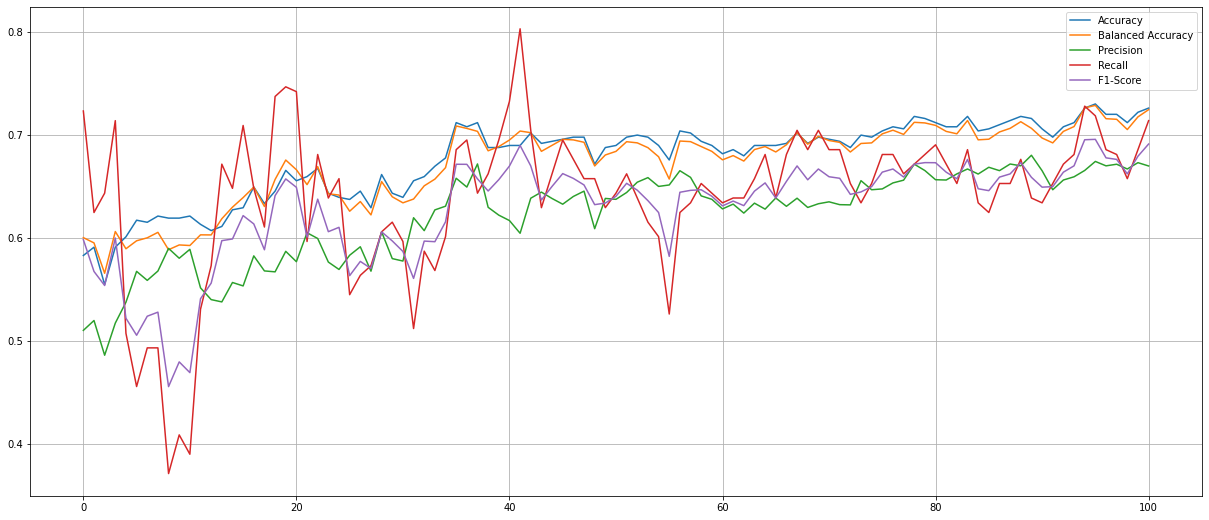

In [9]:
transformStrategies = ['ft', 'glove', 'word2vec']
queryStrategies = ['lcs', 'ms', 'es']
predictors = ['lr', 'svmlin', 'knn', 'bag-svmlin', 'voting']
trials = 5

wsClassifier = Classifier(
    trData=trainingData,
    tsData=testingData,
    pp=True,
    tr='ft',
    itr=iterations,
    ss=seedSize,
    bs=batchSize,
    qs='lcs',
    lf=labelingFuncs,
    tlf=typeLabelFuncs,
    pr='svmlin',
    ftModel=ftModel,
    gloveUO=gloveUO,
    word2vecUO=word2vecUO
    )
wsClassifier.testOnTestingData()

In [7]:
# sampleComments = textLoader("manuallyLabeledComments/sampleComments.txt", "str")
# wsClassifier.predictOnOtherData(30, sampleComments, 'f1')